In [1]:
# 繪圖設定字體顏色(否則黑色會看不到)
import matplotlib as mpl
COLOR1 = 'red'
COLOR2 = 'blue'
mpl.rcParams['text.color'] = COLOR1
mpl.rcParams['axes.labelcolor'] = COLOR2
mpl.rcParams['xtick.color'] = COLOR2
mpl.rcParams['ytick.color'] = COLOR2

#### R-CNN

In [5]:
# # Colab
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# # Colab
# !ls "/content/drive/My Drive/Colab Notebooks"

0.data	2-2.AutoEncoder、影像偵測辨識1.ipynb


(-0.5, 255.5, 255.5, -0.5)

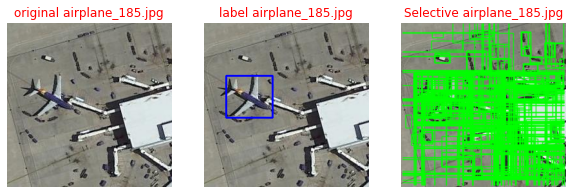

In [7]:
# Selective Search找出候選框
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2
import tensorflow as tf
# 圖檔 和 標示檔路徑
# # Colab
# path = '/content/drive/My Drive/Colab Notebooks/0.data/RCNN/Images/'
# annot = '/content/drive/My Drive/Colab Notebooks/0.data/RCNN/Airplanes_Annotations/'
path = '0.data/RCNN/Images'
annot = '0.data/RCNN/Airplanes_Annotations'

# 設定優化
cv2.setUseOptimized(True)

# 顯示 第一張 標註過後的圖檔
# 1.找出對應的圖檔
    # os.listdir(annot)回傳733個標註檔名的list
filename = os.listdir(annot)[0].split('.')[0] + '.jpg'
img = cv2.imread(os.path.join(path, filename))
img2 = img.copy()
img3 = img.copy()

# 2.標示檔畫框
df = pd.read_csv(os.path.join(annot, os.listdir(annot)[0]))
    # 標示檔 逐行讀取
        # row[0]為 row index
        # 每一行標示 框座標 (左上角x1, 左上角y1, 右下角x2, 右下角y2)
for row in df.iterrows():
    x1 = int(row[1][0].split(" ")[0])
    y1 = int(row[1][0].split(" ")[1])
    x2 = int(row[1][0].split(" ")[2])
    y2 = int(row[1][0].split(" ")[3])
    cv2.rectangle(img2, (x1, y1), (x2, y2), (255, 0, 0), 2)

# 建立 Selective Search 分割器
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
# 設定要進行分割的圖形
ss.setBaseImage(img)
# 使用快速模式(精準度較差)
    # 使用精準模式(速度較慢)：ss.switchToSelectiveSearchQuality()
ss.switchToSelectiveSearchFast()
# 執行 Selective Search 分割
    # 回傳 左上角x, 左上角y, 寬w, 高h
rects = ss.process()
# 逐一畫框
for i, rect in (enumerate(rects)):
    x, y, w, h = rect
    cv2.rectangle(img3, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
    
# 顯示
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img2_RGB = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img3_RGB = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(img_RGB)
plt.title('original ' + filename)
plt.axis('off')
plt.subplot(132)
plt.imshow(img2_RGB)
plt.title('label ' + filename)
plt.axis('off')
plt.subplot(133)
plt.imshow(img3_RGB)
plt.title('Selective ' + filename)
plt.axis('off')

In [8]:
# 地圖找出飛機正負例 (image, label)，用以進行CNN學習
    # Selective Search找出候選框 與 label比較得出IOU → 設定閾值找出正負例
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import cv2
# 圖檔 和 標示檔路徑
# # Colab
# path = '/content/drive/My Drive/Colab Notebooks/0.data/RCNN/Images/'
# annot = '/content/drive/My Drive/Colab Notebooks/0.data/RCNN/Airplanes_Annotations/'
path = '0.data/RCNN/Images'
annot = '0.data/RCNN/Airplanes_Annotations'

# 計算 IOU
    # 參數(第一個框{左上x1, 右下x2, 左上y1, 右下y2}, 第二個框{左上x1, 右下x2, 左上y1, 右下y2})
def get_iou(bb1, bb2):
    # 確保座標正確(否則觸發error)
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']

    x_left = max(bb1['x1'], bb2['x1'])     # 左上角 x最大值 為 交集矩形的左上角x
    y_top = max(bb1['y1'], bb2['y1'])      # 左上角 y最大值 為 交集矩形的左上角y
    x_right = min(bb1['x2'], bb2['x2'])    # 右下角 x最小值 為 交集矩形的右下角x
    y_bottom = min(bb1['y2'], bb2['y2'])   # 右下角 y最小值 為 交集矩形的右下角y
    
    # 沒有交集 回傳0
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # 交集面積
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    # 聯集面積 = 各自面積加總 - 交集面積
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    # 確保 iou在 0-1之間
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

# 找出每一張圖的候選框，只找 iou > 0.7(正例) 或 iou < 0.3(負例)
    # 建立 Selective Search 分割器
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
train_images = []     # 存放所有候選框的圖
train_labels = []     # 存放所有候選框的label (正例標示1，負例標示0)
no = 0
for e, i in enumerate(os.listdir(annot)):
    try:
        # 最多101張圖
        if no > 100:
            break
        no += 1
        if i.startswith("airplane"):
            filename = i.split(".")[0] + ".jpg"
            print(e, filename)
            image = cv2.imread(os.path.join(path, filename))
            imout = image.copy()
            
            # 標示檔取得座標
            df = pd.read_csv(os.path.join(annot, i))
            gtvalues = []
            for row in df.iterrows():
                x1 = int(row[1][0].split(" ")[0])
                y1 = int(row[1][0].split(" ")[1])
                x2 = int(row[1][0].split(" ")[2])
                y2 = int(row[1][0].split(" ")[3])
                gtvalues.append({"x1": x1, "x2": x2, "y1": y1, "y2": y2})
            
            # Selective Search找出候選框
            ss.setBaseImage(image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()
            
            # 此圖的候選框逐一計算，找出正負例(都滿30張之後就印出inside，並換下一張圖)
            counter = 0         # 正例：計算 iou > 0.7 的候選框 數量
            falsecounter = 0    # 負例：計算 iou < 0.3 的候選框 數量
            flag = 0
            fflag = 0
            bflag = 0
            for e, result in enumerate(ssresults):
                if e < 2000 and flag == 0:
                    for gtval in gtvalues:
                        # 候選框
                        x, y, w, h = result
                        # 候選框 與 label框 比較，得出IoU
                        iou = get_iou(gtval, {"x1": x, "x2": x+w, "y1": y, "y2": y+h})
                        if counter < 30:
                            if iou > 0.7:
                                timage = imout[y:y+h, x:x+w]
                                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(1)
                                counter += 1
                        else :
                            fflag = 1
                        if falsecounter < 30:
                            if iou < 0.3:
                                timage = imout[y:y+h, x:x+w]
                                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                                train_images.append(resized)
                                train_labels.append(0)
                                falsecounter += 1
                        else :
                            bflag = 1
                    if fflag == 1 and bflag == 1:
                        print("inside")
                        flag = 1
    except Exception as e:
        print(e)
        print("error in " + filename)
        continue
# 轉np.array
X_new = np.array(train_images)     # shape=(3697, 224, 224, 3)
y_new = np.array(train_labels)

0 airplane_185.jpg
1 airplane_195.jpg
2 airplane_257.jpg
3 airplane_154.jpg
4 airplane_145.jpg
5 airplane_035.jpg
6 airplane_224.jpg
7 airplane_218.jpg
8 airplane_196.jpg
9 airplane_028.jpg
10 airplane_055.jpg
11 airplane_192.jpg
12 airplane_010.jpg
13 airplane_133.jpg
14 airplane_174.jpg
15 airplane_056.jpg
17 airplane_269.jpg
18 airplane_301.jpg
inside
19 airplane_069.jpg
20 airplane_318.jpg
21 airplane_316.jpg
22 airplane_009.jpg
23 airplane_149.jpg
24 airplane_222.jpg
25 airplane_135.jpg
26 airplane_096.jpg
inside
27 airplane_169.jpg
28 airplane_210.jpg
30 airplane_191.jpg
31 airplane_138.jpg
32 airplane_167.jpg
33 airplane_052.jpg
34 airplane_275.jpg
35 airplane_070.jpg
36 airplane_150.jpg
37 airplane_178.jpg
38 airplane_283.jpg
39 airplane_280.jpg
41 airplane_230.jpg
42 airplane_075.jpg
inside
43 airplane_183.jpg
44 airplane_109.jpg
45 airplane_118.jpg
46 airplane_299.jpg
48 airplane_080.jpg
49 airplane_312.jpg
50 airplane_294.jpg
51 airplane_064.jpg
52 airplane_081.jpg
53 airpla

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
63/63 [==============================] - ETA: 0s - loss: 0.2450 - accuracy: 0.9008
Epoch 00001: val_loss improved from inf to 0.23495, saving model to /content/drive/My Drive/Colab Notebooks/model.h5
63/63 [==============================] - 147s 2s/step - loss: 0.2450 - accuracy: 0.9008 - val_loss: 0.2350 - val_accuracy: 0.9127
Epoch 2/25
63/63 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9549
Epoch 00002: val_loss improved from 0.23495 to 0.08997, saving model to /content/drive/My Drive/Colab Notebooks/model.h5
63/63 [==============================] - 142s 2s/step - loss: 0.1225 - accuracy: 0.9549 - val_loss: 0.0900 - val_accuracy: 0.9678
Epoch 3/25
63/63 [==============================] - ETA: 0s - loss: 0.1027 - accuracy: 0.9639
Epoch 00003: val_loss did not improve from 0.08997
63/63 [==============================] - 139s 2s/step - loss: 0.1027 - accuracy: 0.9639 - val

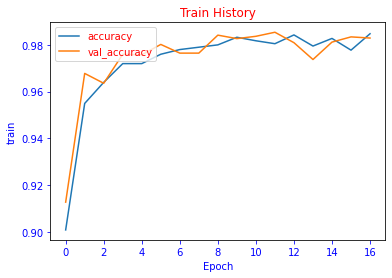

In [9]:
# 使用VGG16 進行正負例學習
from skimage import data, color, io
from skimage.transform import rescale, resize
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
import tensorflow as tf

def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('Epoch')
    plt.ylabel('train')
    plt.legend([train, validation], loc='upper left')
    plt.show()

def trainModel(X_new, y_new, save_dir):
    # 1.模型設定
        # (1)VGG16 with include_top=False
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
        # (2)前面接上 自訂input
    img_width, img_height = 224, 224
    input_shape = (img_height, img_width, 3)
    input_layer = tf.keras.Input(shape=input_shape, name='image_input')
    output_vgg16_conv = model_vgg16_conv(input_layer)
        # (3)後面接上 打平降維 + FCN
    x = tf.keras.layers.Flatten(name='flatten')(output_vgg16_conv)
    x = tf.keras.layers.Dense(256, activation='relu', name='fc2')(x)
    x = tf.keras.layers.Dense(2, activation='sigmoid', name='predictions')(x)
        # (4)模型定義input, output
    model = tf.keras.Model(inputs=input_layer, outputs=x)
        # (5)設定損失函數、優化器
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

    # 2.Data Augmentation
    batch_size = 64
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, horizontal_flip=True, vertical_flip=True)
    validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)
    traindata = train_datagen.flow(x=X_new, y=y_new, batch_size=batch_size)
    validationdata = validation_datagen.flow(x=X_new, y=y_new, batch_size=batch_size)
    
    # 3.callbacks函數：ModelCheckpoint, EarlyStopping
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        save_dir+'model.h5', monitor='val_loss', 
        save_best_only=True, save_weights_only=False, mode='auto', period=1, verbose=1)
    early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=5, mode='auto', verbose=1)
    # 4.train
    epochs = 25
    train_history = model.fit_generator(
        traindata, steps_per_epoch=round(len(X_new)/batch_size), 
        epochs=epochs, validation_data=validationdata, 
        validation_steps=round(len(X_new)/batch_size), 
        callbacks=[checkpoint, early])
    # 訓練結果繪圖
    show_train_history(train_history, 'accuracy', 'val_accuracy')
    return model

# # Colab
# save_dir = '/content/drive/My Drive/Colab Notebooks/'
# save_dir = './0.data/RCNN/'
if (not os.path.exists(save_dir+'model.h5')):
    model = trainModel(X_new, y_new, save_dir)
else:
    model = tf.keras.models.load_model(save_dir+'model.h5')

預測結果 = [[0. 1.]]
plane


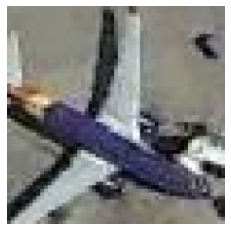

In [13]:
# 訓練資料拿一張出來測試
im = X_new[1]
im_RGB = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im_RGB)
plt.axis('off')

# 模型預測
img = np.expand_dims(im, axis=0)
out = model.predict(img)
print('預測結果 =', out)
if out[0][1] > out[0][0]:
    print("plane")
else:
    print("not plane")

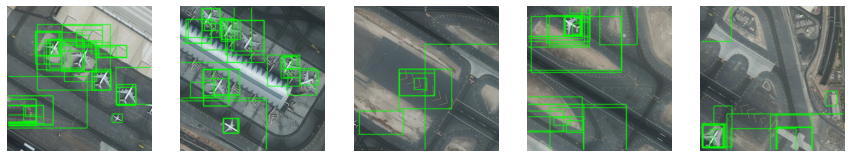

In [17]:
# 另外資料測試，畫出5張 物體(飛機)檢測 結果
  # 許多框重疊，後續可加上NMS步驟
z = 0
plt.figure(figsize=(15, 15))
for e, i in enumerate(os.listdir(path)):
    if i.startswith("4") and z < 5:
        img = cv2.imread(os.path.join(path, i))
        imout = img.copy()
        # Selective Search找出候選框
        ss.setBaseImage(img)
        ss.switchToSelectiveSearchFast()
        ssresults = ss.process()
        # 此張圖所有候選框(2000張為上限)丟進模型預測，是飛機的機率 > 0.95畫出候選框
        for e, result in enumerate(ssresults):
            if e < 2000:
                x, y, w, h = result
                timage = imout[y:y+h, x:x+w]
                resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                img = np.expand_dims(resized, axis=0)
                out = model.predict(img)
                if out[0][1] > 0.95:
                    cv2.rectangle(imout, (x, y), (x+w, y+h), (0, 255, 0), 1, cv2.LINE_AA)
        plt.subplot(1, 5, z+1)
        imout_RGB = cv2.cvtColor(imout, cv2.COLOR_BGR2RGB)
        plt.imshow(imout_RGB)
        plt.axis('off')
        z += 1